In [1]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm_notebook
import seaborn as sns
import pandas as pd
import numpy as np
import collections
from collections import Counter
import glob
import pickle
import random
from sklearn.metrics.pairwise import cosine_similarity
import sys
from sklearn.preprocessing import LabelBinarizer

In [4]:
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(0, '../../src/models/')
sys.path.insert(0, '../../src/features/')

In [5]:
# Own Functions
from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify

In [7]:
output = 233

In [8]:
model = load_CUB_Bert("../../models/", 'saved_weights_SPECIES_PLANT_233.pt', outputsize=output)

Local Success


In [9]:
POWO = pickle.load(open('../../data/processed/RDF_text_POWOSET.pkl', 'rb'))
TEST = pickle.load(open('../../data/processed/RDF_text_TESTSET.pkl', 'rb'))

In [12]:
data_list = []
for key in POWO.keys():
    data_list += POWO[key]

count = Counter(data_list)

In [14]:
#count

In [15]:
lb = LabelBinarizer()
keys = np.array([key for key in POWO.keys()])
keys_encoded = lb.fit_transform(keys)

In [16]:
def WhichPlant(span, model):

    """
    Uses a trained bert classifier to see if a span
    belongs to a species description or otherwise.
    """
        
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation='only_first', )
        # Predict class
        outputs = model(**inputs)
        # Get prediction values
        exps = torch.exp(outputs)
        # Get class
        probs = exps.detach().numpy()
        
        return np.squeeze(probs)

In [17]:
plant_idx = 33
plant = list(POWO.keys())[plant_idx]
print('NAME:', plant)
plant_list = []
for triples in POWO[plant][0:]:
    rank = count[triples]
    # TESTING
    if 'sub parts' in triples:
        continue
    if 'main parts'  in triples:
        continue
        
    plant_list.append((triples, rank))
    
plant_list = list(set(plant_list))   
plant_list = sorted(plant_list, key=lambda x: x[1], reverse=True)

NAME: Annona muricata


In [18]:
#plant = list(data.keys())[1]
print(plant)

probs_stack = np.empty((0, output), float)
text_span = []

#for row in tqdm_notebook(data_text[plant]):
#for (row, _) in tqdm_notebook(reversed(plant_list)):
for (row, _) in tqdm_notebook(plant_list[0:]):
    
    
    #if count[row] == 1:
    #    continue
    
    if len(text_span) < 50:
        text_span.append(row)
    else:
        del text_span[0]
        text_span.append(row)
    span = ' '.join(text_span)
    
    #probs = WhichPlant(span, model=model)
    probs = WhichPlant(row, model=model)
    probs_stack = np.vstack((probs_stack, probs))

Annona muricata


  0%|          | 0/10 [00:00<?, ?it/s]

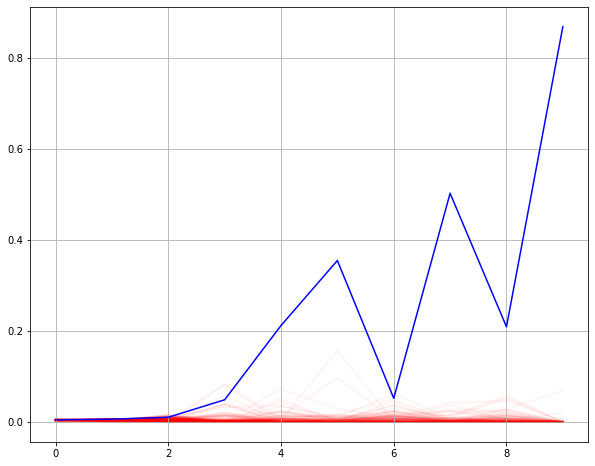

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, output):
    if i == np.where(lb.classes_ == plant)[0][0]:
        ax.plot(probs_stack[:, i], color='blue', alpha=1, markersize=5, zorder=2)
    else:
        
        ax.plot(probs_stack[:, i], color='red', alpha=0.05, zorder=1)
plt.grid()

In [27]:
#pos_array = np.array(data[plant][0:])
#idx = np.where(lb.classes_ == plant)[0][0]
#pos_array[probs_stack[:, idx] > .9]

In [ ]:
'''
data_plants = collections.defaultdict(list)

for plant in tqdm_notebook(list(data.keys())[0:10]):
    text_span = ''
    
    plant_list = []
    for triples in data[plant][0:]:
        rank = count[triples]
        plant_list.append((triples, rank))

    plant_list = list(set(plant_list))   
    plant_list = sorted(plant_list, key=lambda x: x[1], reverse=True)    
    
    
    for (row, _) in tqdm_notebook(plant_list, leave=False):
    #for row in important_stuff:
        text_span += f' {row}.' 
        probabilities_stacked = WhichPlant(row, model=model)
        idx = np.where(lb.classes_ == plant)[0][0]
        data_plants[plant].append(probabilities_stacked[idx])
'''

In [28]:
'''
fig, ax = plt.subplots(figsize=(10, 8))

for plant in data_plants.keys():
    ax.plot(data_plants[plant], alpha=,)
#plt.legend()
plt.show()
'''

'\nfig, ax = plt.subplots(figsize=(10, 8))\n\nfor plant in data_plants.keys():\n    ax.plot(data_plants[plant], alpha=,)\n#plt.legend()\nplt.show()\n'

In [24]:
def check_values(sents):
    
    count = 0
    # Check other combinations
    for species in POWO.keys():
        length = len(set(sents).intersection(POWO[species]))
        if length == len(sents):
            count += 1
        
    return count

In [25]:
text_list = []
pred_sing = []
pred_mult = []
single_other = []
multip_other = []

for idx, (row, value) in enumerate(tqdm_notebook(plant_list[0:])):
    text_list.append(row)
    pred_sing.append(output / value / output)
    if idx != 0 and pred_mult[-1] == 1:
        pred_mult.append(1)
    else:
        pred_mult.append(output / check_values(text_list) / output)
            

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
pred_sing = []
pred_all_single = np.zeros(shape=(len(plant_list[0:]), output))

for idx, (row, value) in enumerate(tqdm_notebook(plant_list[0:])):
    temp_s = []
    for x in POWO.keys():
        if row in POWO[x]:
            temp_s.append(output / value / output)
        else:
            temp_s.append(0)
    pred_all_single[idx] = temp_s


  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
#len(species)

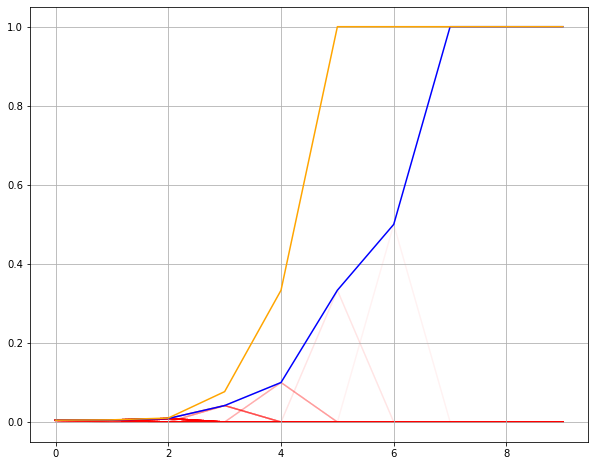

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, output):
    if i == plant_idx:
        ax.plot(pred_all_single[:, i], color='blue', alpha=1, markersize=5, zorder=2, )
    else:
        ax.plot(pred_all_single[:, i], color='red', alpha=0.05, zorder=1,)
plt.plot(pred_mult, color='orange')
plt.grid()

In [46]:
text_list[0:np.array(pred_mult).argmax()]

['Spikelet disarticulating below floret.',
 'Spikelet comprising florets.',
 'Glume is similar.',
 'Glume is thinner than fertile lemma.',
 'Spikelet is dorsally compressed.',
 'Fertile lemma is lanceolate.',
 'Spikelet is elliptic.']